In [399]:
!pwd

/home/william/language_modelling_andrej/intro_pytorch/Language_Modelling_intro/notebooks


In [418]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [419]:
words = open('../../names.txt', 'r').read().splitlines()

In [420]:
len(words)

32034

In [421]:
total_length= 0
for word in words:
    total_length+= len(word)
average_length = total_length/len(words)
average_length

6.122245114565774

# Creating Dataset

In [422]:
unique = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(unique)}
stoi['.'] =0
itos = {i:s for s, i in stoi.items()}
itos;

In [423]:

test_split = int(0.9*len(words))
train_split = int(0.8*len(words))
print(f' {test_split=}, {train_split=}')

 test_split=28830, train_split=25627


In [424]:
# def delete_multiple_element(list_object, indices):
#     indices = sorted(indices, reverse=True)
#     for idx in indices:
#         if idx < len(list_object):
#             list_object.pop(idx)
# def sample_and_remove(list_object, num):
#     #num is number of items to remove
#     original_data= list_object
#     data = list_object
#     sample= random.sample(list(enumerate(data)), num)
#     samples = [s[1] for s in sample]
#     sample_ids= [s[0] for s in sample]
#     delete_multiple_element(data, sample_ids)
#     return samples, data


In [425]:
def train_test_val_split(words):
    
    random.shuffle(words)
    train = words[:train_split]
    val = words[train_split:test_split]
    test= words[test_split:]
    return train, val, test

In [426]:
train, val, test = train_test_val_split(words)

In [427]:
n_gram = 6
def build_dataset(words, n_gram=6):
    X = []
    Y = []
    num =0
    for word in words:
        word = word + '.'
    #     print(word)
        context = [0]* n_gram
        for ch in word:
            num +=1
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    #         print(f"{''.join((itos[c] for c in context))} ----> {itos[ix]}")
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y
X_train, y_train = build_dataset(train)
X_val, y_val = build_dataset(val)
X_test, y_test = build_dataset(test)


In [428]:
X_train.shape, X_val.shape, X_test.shape

(torch.Size([182570, 6]), torch.Size([22832, 6]), torch.Size([22752, 6]))

In [429]:
y_train.shape, y_val.shape, y_test.shape

(torch.Size([182570]), torch.Size([22832]), torch.Size([22752]))

In [478]:
g = torch.Generator().manual_seed(0)
emb_dim = 10 # embedding dimensions
C = torch.randn((27, emb_dim), generator=g)
W1 = torch.randn((n_gram*emb_dim, 300),generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)

In [479]:
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [480]:
num_params = 0
for p in parameters:
    num_params += p.nelement()
num_params

26697

In [481]:
loss_history = []
l_rates_e= torch.linspace(-3, -1, 1000)
l_rates = l_rates_e.exp()
l_rates;

In [482]:
batch_size = 64
batch =torch.randint(low=0, high=X_train.shape[0], size=(batch_size,))
X_train[batch].shape
# Y[batch];

torch.Size([64, 6])

In [ ]:
for epoch in range(200000):
    #batch construct
    batch =torch.randint(low=0, high=X_train.shape[0], size=(batch_size,))
    #forward pass
    #embedding layer
    emb = C[X_train[batch]]
    # emb = emb.view(-1, n_gram*emb_dim)
    #hidden layer
    h = torch.tanh((emb.view(-1, n_gram*emb_dim) @ W1) + b1)
    # h = torch.tanh(h)
    # output layer
    logits = (h @ W2) + b2
    # loss
    loss = F.cross_entropy(logits, y_train[batch])
    print(f'{loss=}, {epoch=}')
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update parameters
    lr = 0.075 if epoch < 180000 else 0.001
    for p in parameters:
        p.data += -lr*p.grad
    
    #track stats
    loss_history.append(loss)


In [487]:
#loss on train dataset
emb = C[X_train]
# emb = emb.view(-1, n_gram*emb_dim)
#hidden layer
h = torch.tanh((emb.view(-1, n_gram*emb_dim) @ W1) + b1)
# h = torch.tanh(h)
# output layer
logits = (h @ W2) + b2
# loss
loss = F.cross_entropy(logits, y_train)
loss

tensor(2.1880, grad_fn=<NllLossBackward0>)

In [488]:
#loss on val dataset
emb = C[X_val]
# emb = emb.view(-1, n_gram*emb_dim)
#hidden layer
h = torch.tanh((emb.view(-1, n_gram*emb_dim) @ W1) + b1)
# h = torch.tanh(h)
# output layer
logits = (h @ W2) + b2
# loss
loss = F.cross_entropy(logits, y_val)
loss

tensor(2.2157, grad_fn=<NllLossBackward0>)

In [471]:
len(loss_history)

0

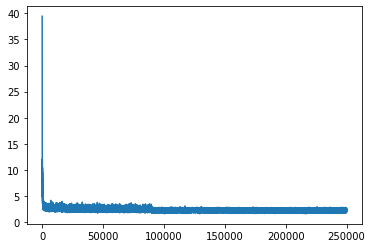

In [490]:
#determining learning rate
plt.plot(range(250000), loss_history)

In [507]:
for _ in range(20):
    out = []
    context = [0]*n_gram
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


datty.
lehanna.
zelyi.
lexsen.
elijin.
noniloria.
rhily.
anvortten.
rafsy.
jeelia.
likanaor.
emysta.
lamark.
estane.
canzrugt.
geracisa.
callekl.
sean.
riviah.
ibizane.
